# Background

This is a supporting notebook for the [un_peacekeepers.ipynb](./un_peacekeepers.ipynb) containing exploration of the national composition of UN peacekeeper casualties. I split the notebooks for better legibility.

In [ ]:
%%capture
!pip install bar_chart_race

In [13]:
%%capture
!pip install pillow

In [2]:
# Start by importing the necessary libraries and loading our data
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.colors as mcolors
import matplotlib.patheffects as path_effects
import numpy as np
import itertools
import time
import bar_chart_race as bcr
import contextlib
import sys
from IPython.display import display


url = f'https://drive.google.com/uc?export=download&id=1YTJ2V4vfMRSBIkoGl17EUlgnDP-9vZMp'
df = pd.read_csv(url, parse_dates=['incident_date'])

I will start with descriptive statistics:

,casualty_nationality,fatality_count
0,India,181
1,Pakistan,171
2,Bangladesh,168
3,Nigeria,160
4,Ghana,156
5,Ethiopia,141
6,Canada,124
7,France,117
8,Democratic Republic of the Congo,113
9,United Kingdom of Great Britain and Northern I...,107


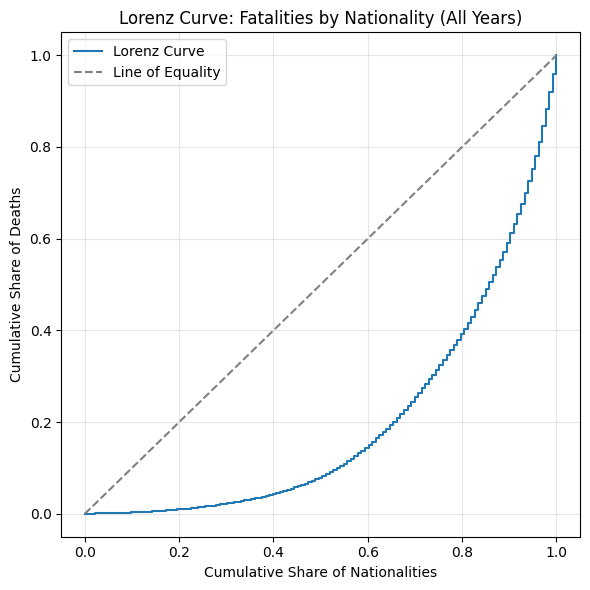

Gini Coefficient for (All Years): 0.596


In [4]:
total_fatalities = len(df)

casualty_nationality_counts = df['casualty_nationality'].value_counts().reset_index()
casualty_nationality_counts.columns = ['casualty_nationality', 'fatality_count']
#casualty_nationality_counts['percent'] = (casualty_nationality_counts['fatality_count'] / total_fatalities * 100).round(2)
with pd.option_context('display.max_rows', None):
    display(casualty_nationality_counts)
    print()


def plot_lorenz_curve_by_nationality(data, title_suffix=""):
    nationality_counts = data['casualty_nationality'].value_counts().sort_values()

    if nationality_counts.sum() == 0:
        print(f"No fatalities data to plot for {title_suffix}")
        return

    values = nationality_counts.values
    total = values.sum()
    values_normalized = values / total
    cumulative = np.cumsum(values_normalized)
    cumulative = np.insert(cumulative, 0, 0)

    x = np.linspace(0, 1, len(cumulative))

    B = np.trapz(cumulative, x)
    A = 0.5 - B
    gini = A / 0.5

    plt.figure(figsize=(6, 6))
    plt.plot(x, cumulative, drawstyle='steps-post', label='Lorenz Curve')
    plt.plot([0, 1], [0, 1], linestyle='--', color='gray', label='Line of Equality')
    plt.title(f'Lorenz Curve: Fatalities by Nationality {title_suffix}')
    plt.xlabel('Cumulative Share of Nationalities')
    plt.ylabel('Cumulative Share of Deaths')
    plt.legend()
    plt.grid(alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(f"Gini Coefficient for {title_suffix}: {gini:.3f}")



plot_lorenz_curve_by_nationality(df, title_suffix="(All Years)")



Representatives of 132 identified countries have lost their lives serving UN peacekeeping missions. 20 nationalities represent half of the deaths. 

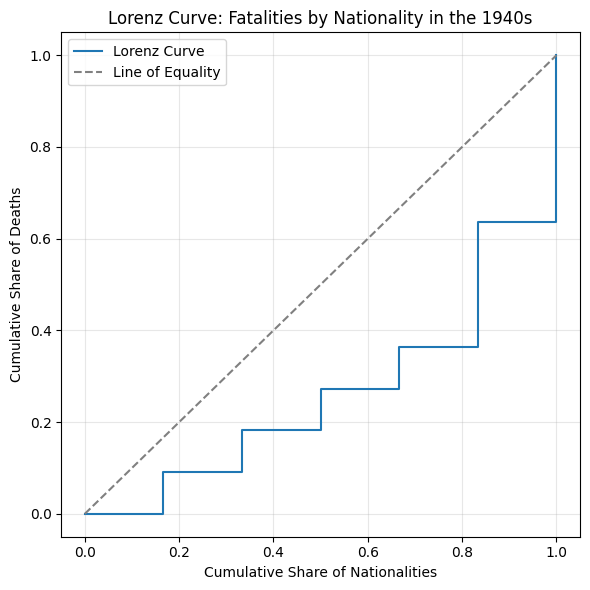

Gini Coefficient for in the 1940s: 0.318


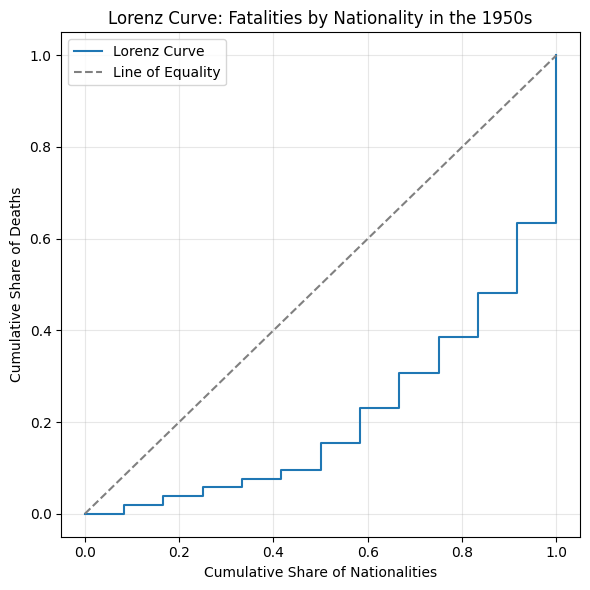

Gini Coefficient for in the 1950s: 0.503


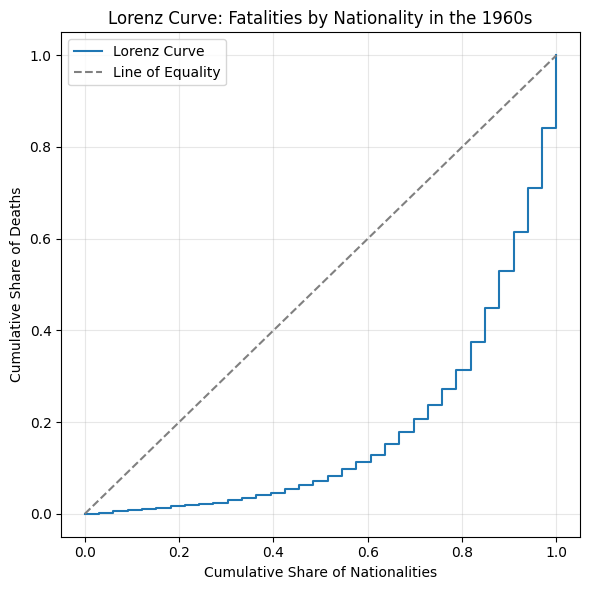

Gini Coefficient for in the 1960s: 0.621


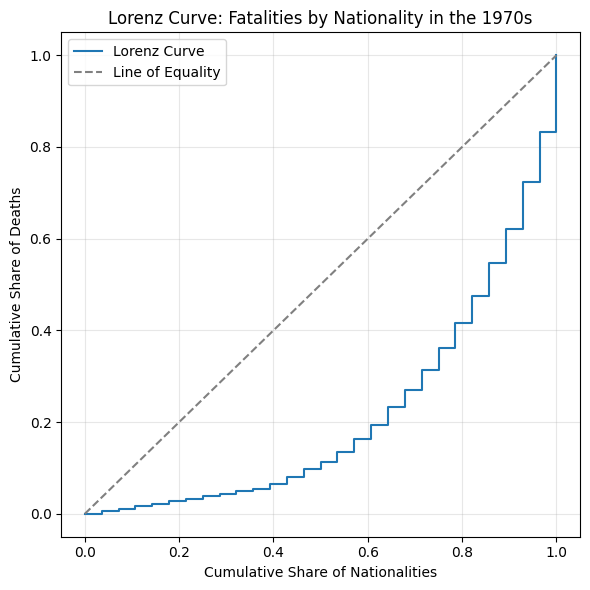

Gini Coefficient for in the 1970s: 0.540


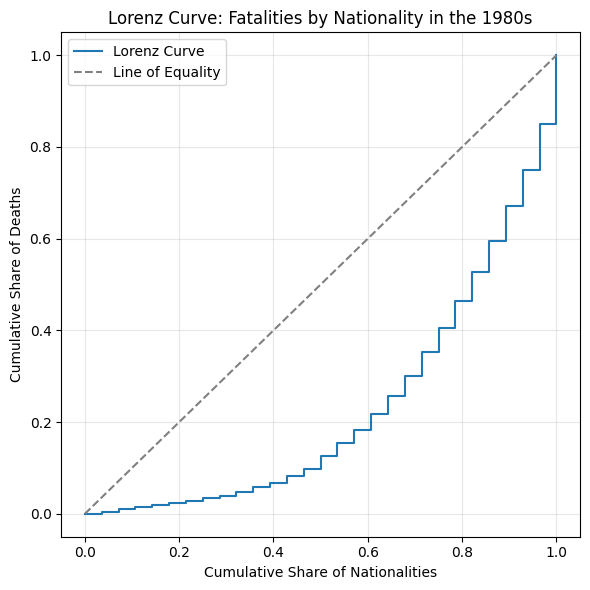

Gini Coefficient for in the 1980s: 0.509


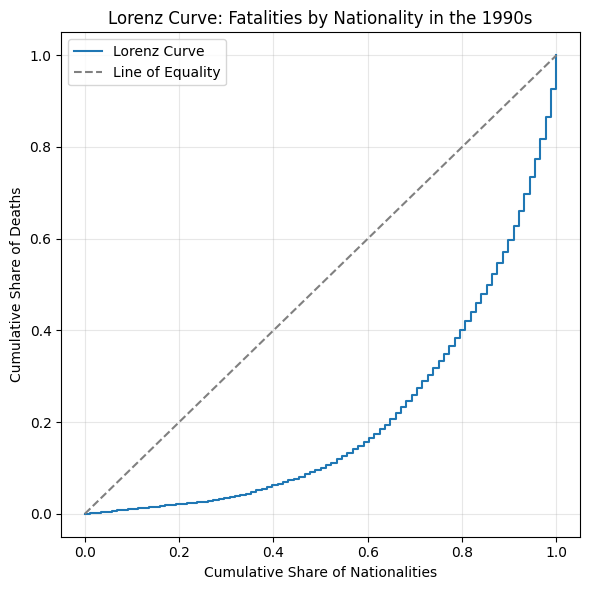

Gini Coefficient for in the 1990s: 0.575


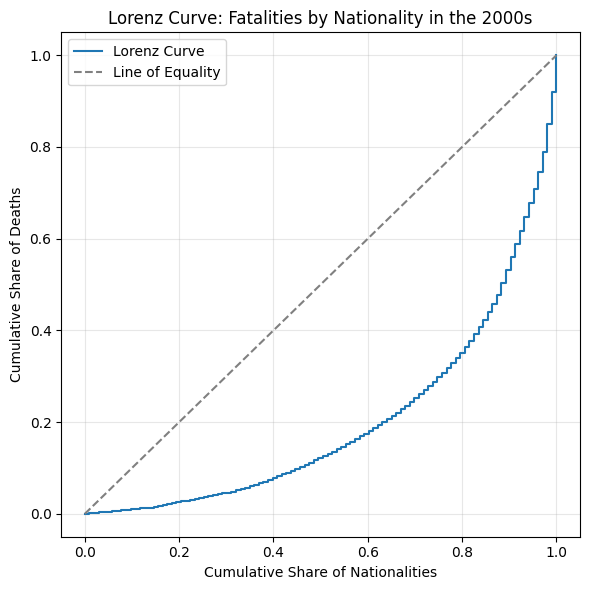

Gini Coefficient for in the 2000s: 0.590


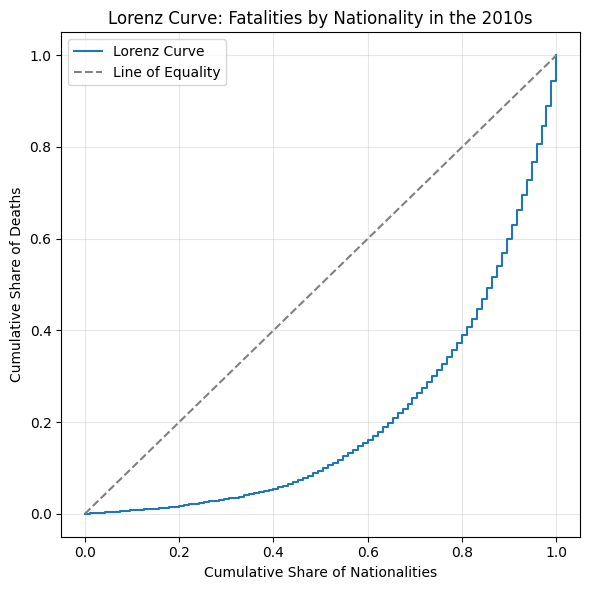

Gini Coefficient for in the 2010s: 0.582


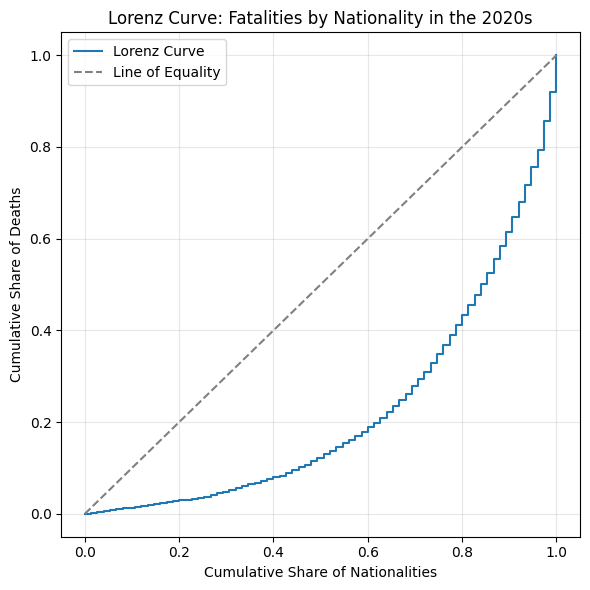

Gini Coefficient for in the 2020s: 0.543


In [25]:
df['year'] = df['incident_date'].dt.year
df['decade'] = (df['year'] // 10) * 10
df = df[df['decade'].between(1940, 2029)]

for decade in sorted(df['decade'].unique()):
    decade_df = df[df['decade'] == decade]
    plot_lorenz_curve_by_nationality(decade_df, title_suffix=f"in the {decade}s")


the Gini ciefficient has not significantly changed between 1950-s and 2020-s

## Nationalities with the most fatalities

Let's visualise the nationalities that suffered most casualties throughout UN peacekeeping missions. We will use two instruments: a running bar chart for years for a quick understanding of the dynamics, and a more consise heatmap.

In [ ]:
import pandas as pd
import bar_chart_race as bcr

df['year'] = df['incident_date'].dt.year
df_bar = df.groupby(['year', 'casualty_nationality']).size().reset_index(name='fatalities')
pivot_df = df_bar.pivot(index='year', columns='casualty_nationality', values='fatalities').fillna(0)

top_nationalities = pivot_df.sum().sort_values(ascending=False).head(10).index
pivot_df = pivot_df[top_nationalities]

# Convert index to datetime
pivot_df.index = pd.to_datetime(pivot_df.index.astype(str), format='%Y')

# Fill missing years (important for animation to be smooth)
full_range = pd.date_range(start=pivot_df.index.min(), end=pivot_df.index.max(), freq='YS')
pivot_df = pivot_df.reindex(full_range, fill_value=0)

# Create the animated bar chart race
with contextlib.redirect_stdout(sys.__stdout__):
    bcr.bar_chart_race(
        df=pivot_df,
        filename='fatalities_by_year.gif',  # or None if you just want to display
        orientation='h',
        sort='desc',
        n_bars=10,
        fixed_order=False,
        steps_per_period=10,
        interpolate_period=True,
        period_length=1000,
        title='Top 10 Nationalities by Fatalities Per Year',
        bar_size=0.95,
        period_fmt='%Y'
    )

The animation shows the nationalities that suffered most casualties in a given year.

![fatalities_by_year.gif](./images/fatalities_by_year.gif)

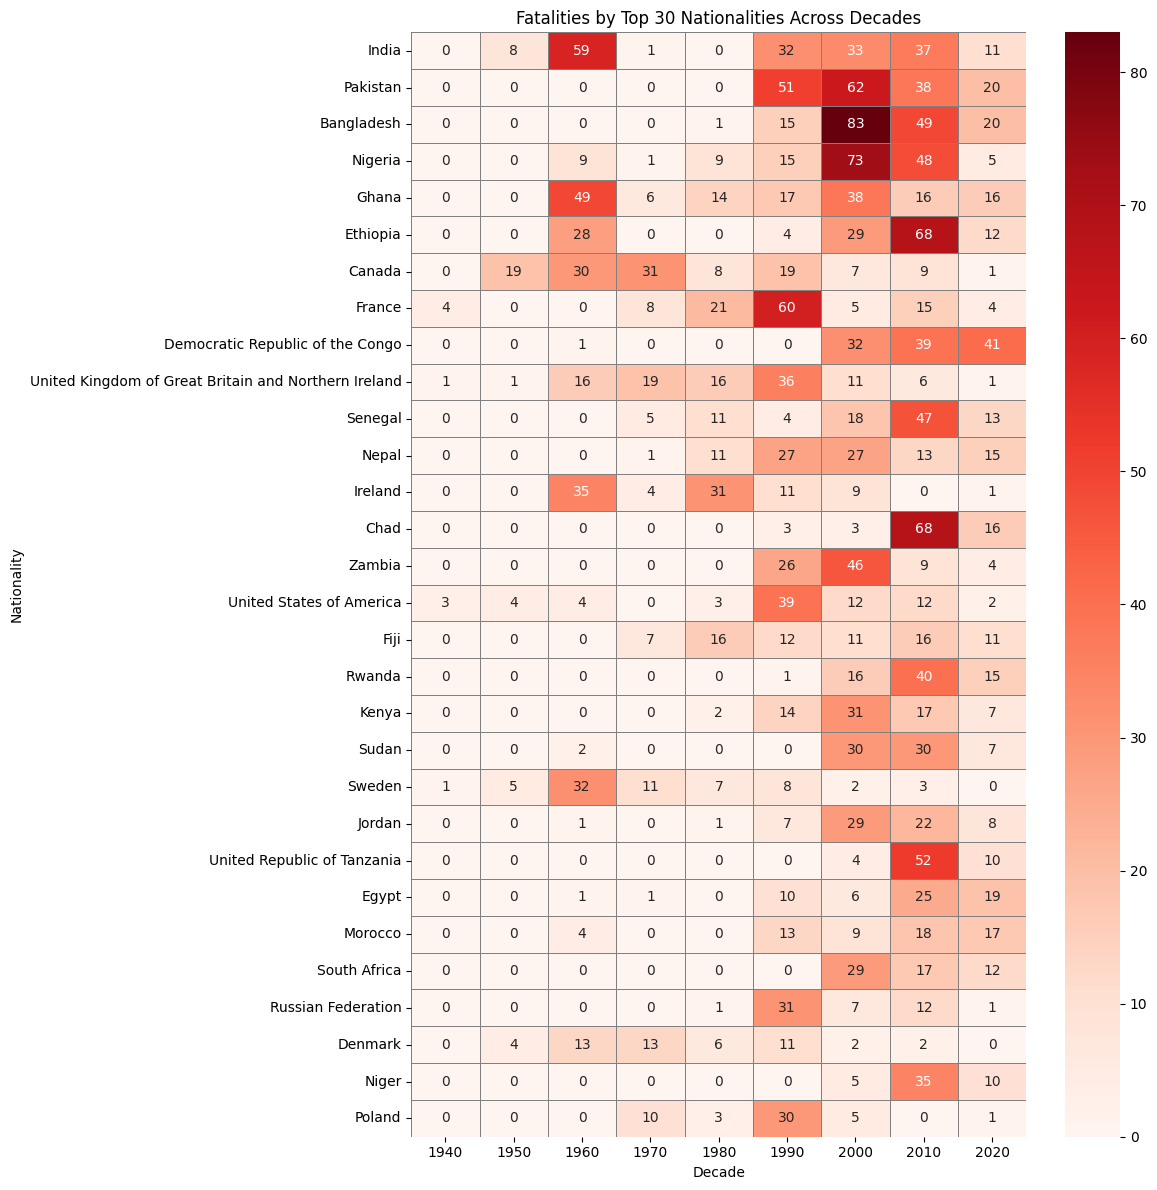

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Step 1: Prepare data
heatmap_df = (
    df.groupby(['decade', 'casualty_nationality'])
    .size()
    .reset_index(name='fatalities')
)

# Step 2: Get top 30 countries by total fatalities across all decades
top_30_countries = (
    heatmap_df.groupby('casualty_nationality')['fatalities']
    .sum()
    .sort_values(ascending=False)
    .head(30)
    .index
)

# Step 3: Filter for only top 30 countries
filtered = heatmap_df[heatmap_df['casualty_nationality'].isin(top_30_countries)]

# Step 4: Pivot for heatmap
pivot = filtered.pivot(index='casualty_nationality', columns='decade', values='fatalities').fillna(0)

# Optional: Sort countries by total fatalities (helps readability)
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).index]

# Step 5: Plot heatmap
plt.figure(figsize=(12, 12))  # adjust size based on number of countries
sns.heatmap(pivot, annot=True, fmt=".0f", cmap="Reds", linewidths=0.5, linecolor='gray')
plt.title('Fatalities by Top 30 Nationalities Across Decades')
plt.xlabel('Decade')
plt.ylabel('Nationality')
plt.tight_layout()
plt.show()


Let us examine the commonly held belief that UN peacekeeping fatalities disproportionately affect lower-income countries. To test this narrative, we will use GDP per capita data (in current US dollars) from the World Bank, available from 1960 onward.

Our approach consists of the following steps:

1) Download GDP per capita data from the [World Bank](https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv).

2) Standardize country names between the GDP dataset and the peacekeeping fatalities dataset to ensure compatibility.

3) For each decade starting from 1960, calculate:

* The median GDP per capita for each country within that decade.

* The total number of UN peacekeeping fatalities attributed to each country during the same decade.

Rank countries within each decade based on both GDP and fatalities.

4) Calculate Spearman’s rank correlation coefficient for each decade to determine whether there is a relationship between economic status and peacekeeping fatalities.

 

In [8]:
import pandas as pd
import zipfile
import requests
import io

# Step 1: Download and extract World Bank GDP per capita CSV
url = "https://api.worldbank.org/v2/en/indicator/NY.GDP.PCAP.CD?downloadformat=csv"
response = requests.get(url)

# Unzip the downloaded content
with zipfile.ZipFile(io.BytesIO(response.content)) as z:
    # Find the file that contains "API_" and ends with ".csv"
    gdp_filename = [f for f in z.namelist() if f.startswith("API_") and f.endswith(".csv")][0]
    with z.open(gdp_filename) as f:
        gdp = pd.read_csv(f, skiprows=4)  # skip metadata rows

# Step 2: Get country names from GDP dataset
world_bank_countries = set(gdp['Country Name'].dropna().unique())

# Step 3: Get unique country names from your casualties dataframe
your_countries = set(df['casualty_nationality'].dropna().unique())

# Step 4: Compare names
missing_in_world_bank = sorted(your_countries - world_bank_countries)

# Step 5: Save to CSV
missing_df = pd.DataFrame({'country_not_in_world_bank': missing_in_world_bank})
missing_df.to_csv('countries_missing_in_world_bank.csv', index=False)

display(f"{len(missing_df)} countries from your dataset are not found in the World Bank GDP dataset.")
display(missing_df)

'20 countries from your dataset are not found in the World Bank GDP dataset.'

,country_not_in_world_bank
0,Bolivia (Plurinational State of)
1,Congo
2,Côte dIvoire
3,Democratic Republic of the Congo
4,Egypt
5,Gambia
6,Iran (Islamic Republic of)
7,Kyrgyzstan
8,Republic of Korea
9,Serbia and Montenegro


In [12]:
# Step 1: Define the mapping for standardization
country_name_map = {
    "Bolivia (Plurinational State of)": "Bolivia",
    "Congo": "Congo, Rep.",
    "Côte dIvoire": "Cote d'Ivoire",
    "Democratic Republic of the Congo": "Congo, Dem. Rep.",
    "Egypt": "Egypt, Arab Rep.",
    "Gambia": "Gambia, The",
    "Iran (Islamic Republic of)": "Iran, Islamic Rep.",
    "Kyrgyzstan": "Kyrgyz Republic",
    "Republic of Korea": "Korea, Rep.",
    "Serbia and Montenegro": "Serbia",
    "Slovakia": "Slovak Republic",
    "State of Palestine": "West Bank and Gaza",
    "Türkiye": "Turkiye",
    "United Republic of Tanzania": "Tanzania",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "United States of America": "United States",
    "Venezuela (Bolivarian Republic of)": "Venezuela, RB",
    "Yemen": "Yemen, Rep."
}

# Step 2: Create a new copy of df
df_standardized = df.copy()

# Step 3: Apply name replacements
df_standardized['casualty_nationality'] = df_standardized['casualty_nationality'].replace(country_name_map)

# Step 4: Remove unwanted rows
df_standardized = df_standardized[
    ~df_standardized['casualty_nationality'].isin(["Yugoslavia", "ZZ [Undetermined]"])
]

# Step 5: Check remaining unmatched
remaining_unmatched = sorted(set(df_standardized['casualty_nationality'].unique()) - set(gdp['Country Name'].unique()))

print("Standardization complete.")
print(f"{len(remaining_unmatched)} unmatched countries remaining:")
print(remaining_unmatched)


Standardization complete.
1 unmatched countries remaining:
[nan]


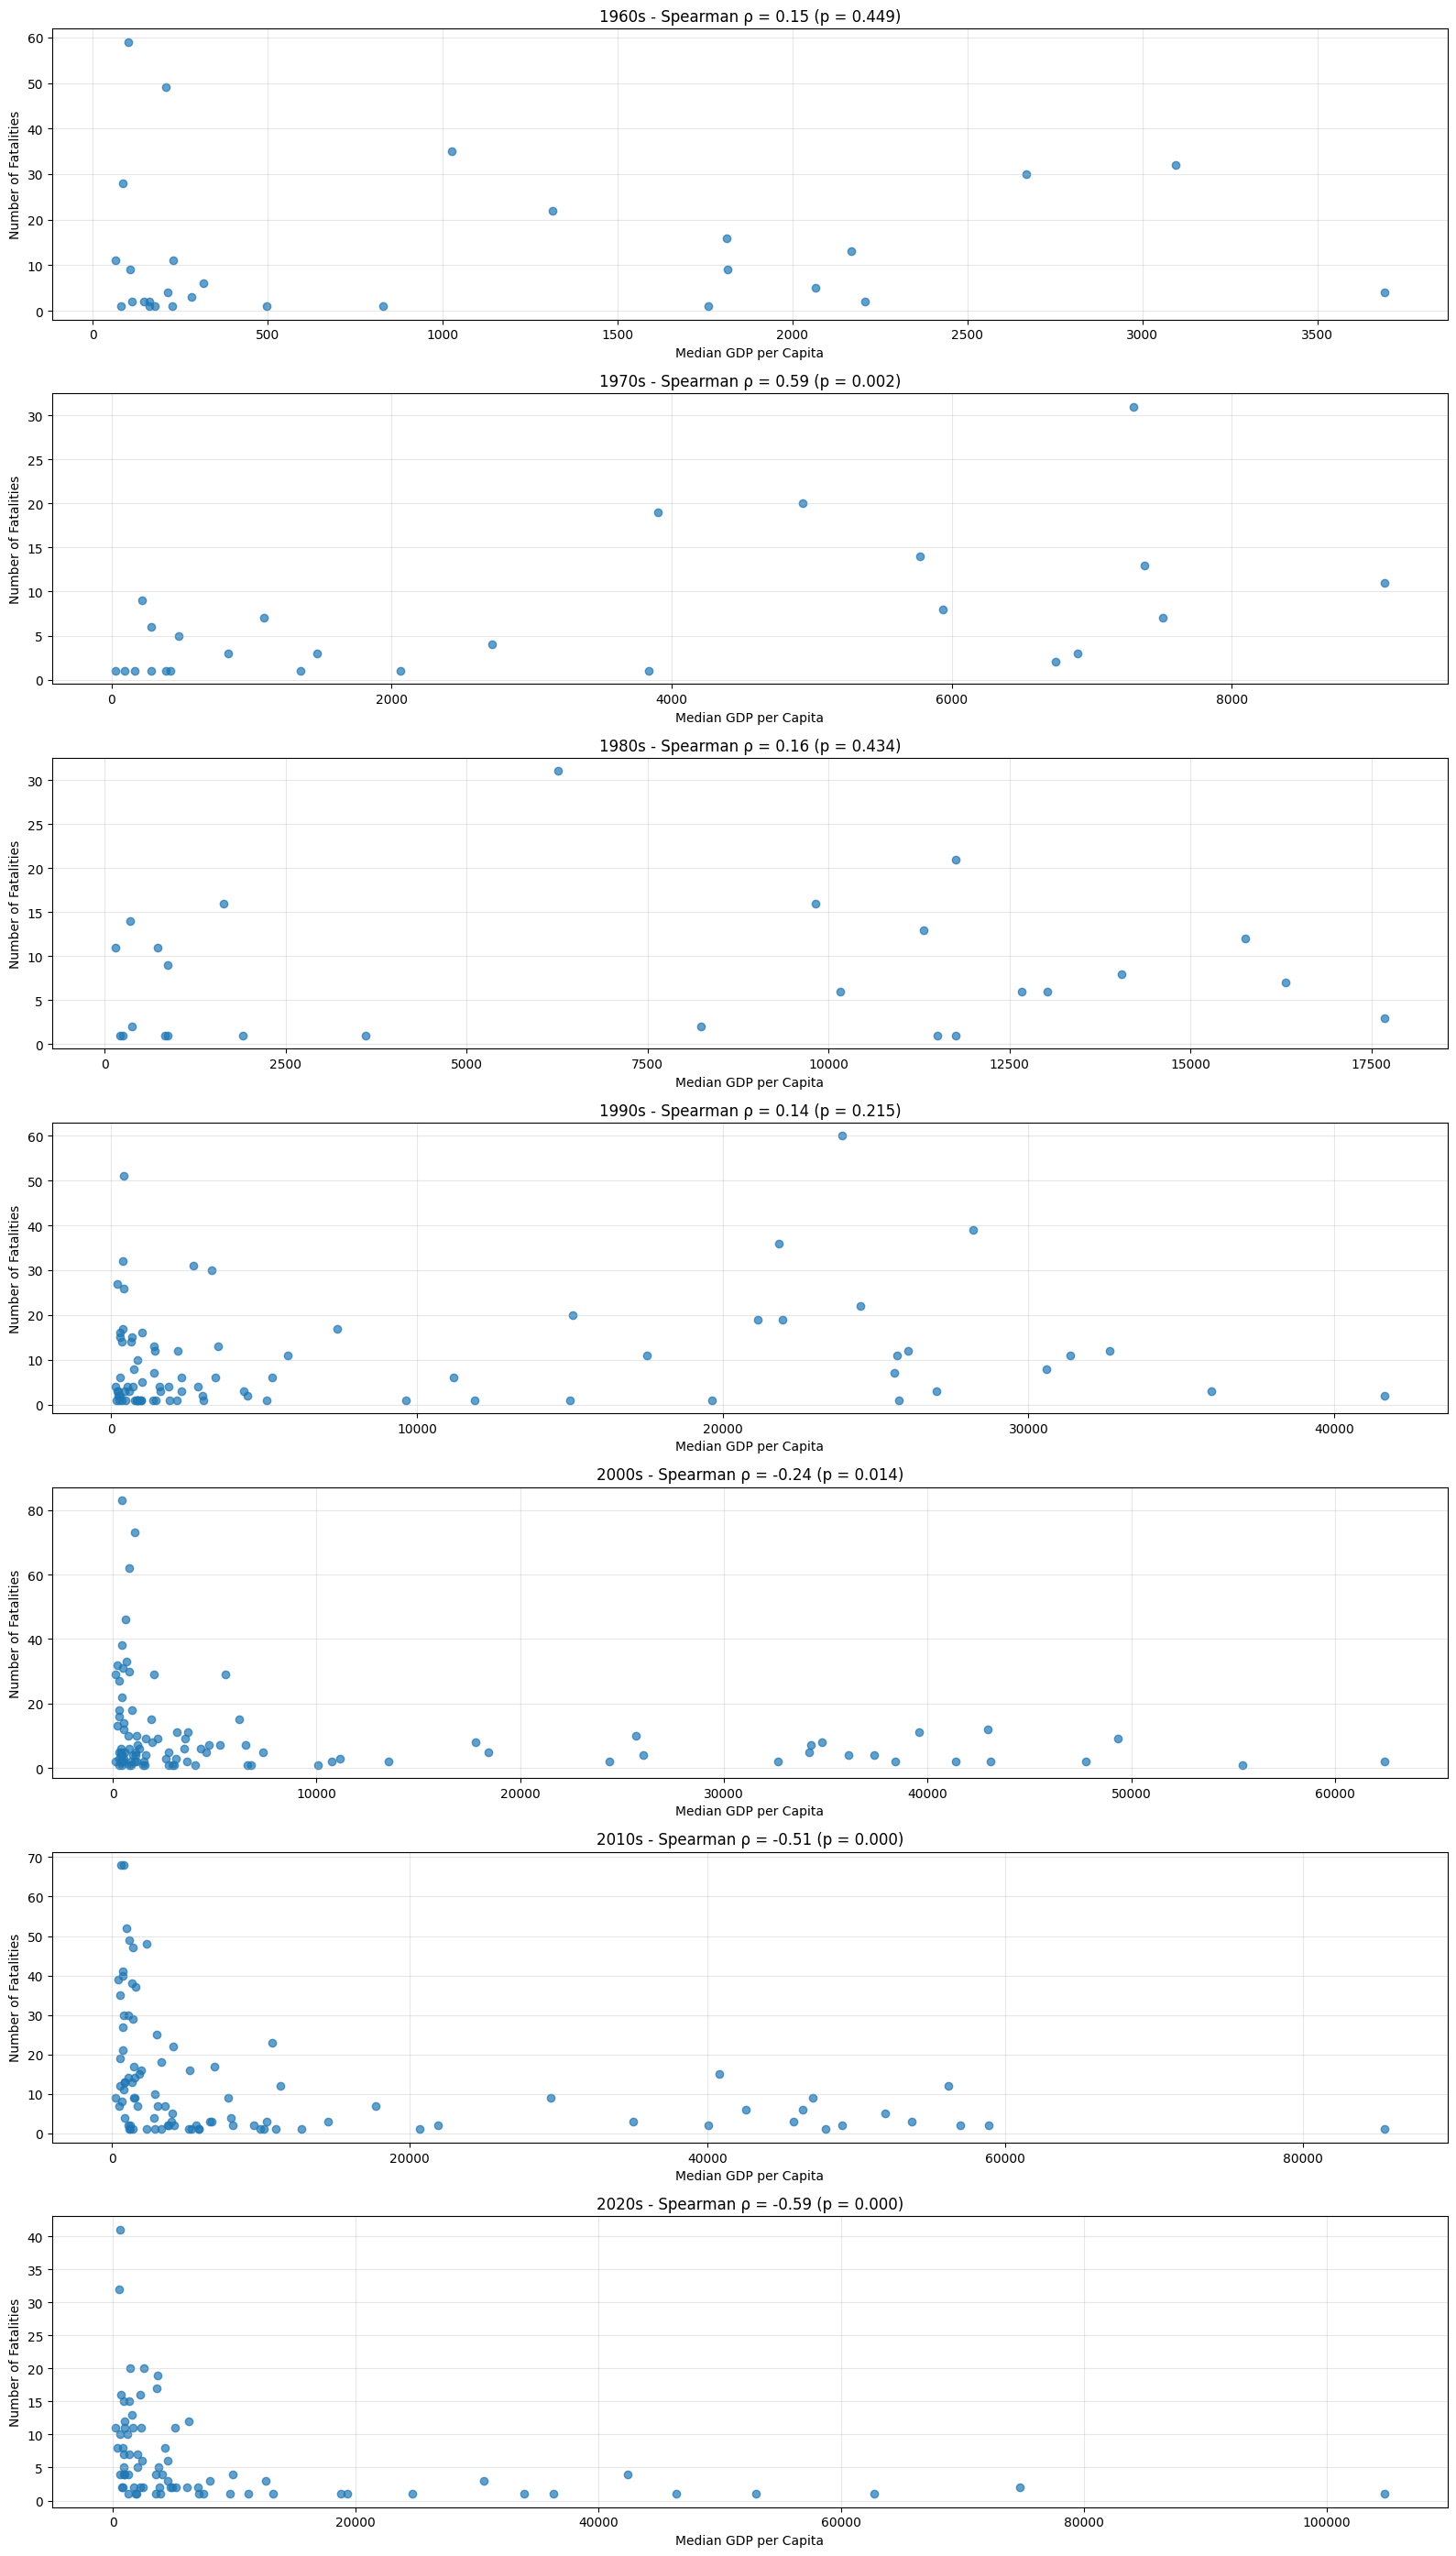

'\nSpearman Correlation by Decade:'

,decade,spearman_corr,p_value
0,1960,0.146323,4.488096e-01
1,1970,0.585991,1.657231e-03
2,1980,0.160465,4.335884e-01
3,1990,0.135088,2.149338e-01
4,2000,-0.244121,1.388644e-02
5,2010,-0.514328,9.740236e-08
6,2020,-0.592630,2.657459e-08


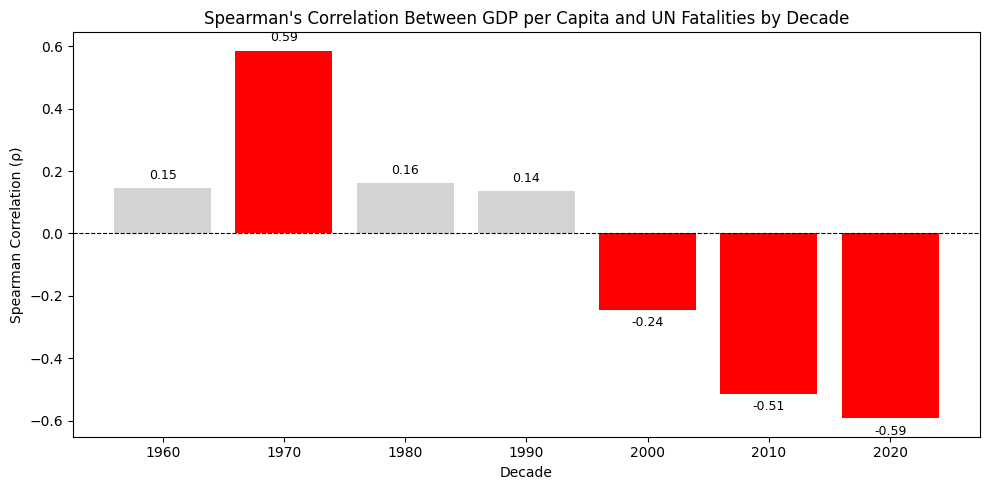

In [14]:
import numpy as np

# Step 1: Extract GDP columns (years 1960–2029 if present)
gdp_years = [str(y) for y in range(1960, 2030) if str(y) in gdp.columns]
gdp_filtered = gdp[['Country Name'] + gdp_years].copy()

# Step 2: Melt the GDP data to long format
gdp_long = gdp_filtered.melt(id_vars='Country Name', var_name='year', value_name='gdp_per_capita')
gdp_long['year'] = gdp_long['year'].astype(int)
gdp_long = gdp_long.dropna(subset=['gdp_per_capita'])

# Step 3: Assign decades
gdp_long['decade'] = (gdp_long['year'] // 10) * 10

# Step 4: Compute median GDP per country per decade
gdp_decade = (
    gdp_long.groupby(['Country Name', 'decade'])['gdp_per_capita']
    .median()
    .reset_index()
)

# Step 5: Create a fatalities dataframe from df_standardized
df_standardized['year'] = df_standardized['incident_date'].dt.year
df_standardized = df_standardized[df_standardized['year'] >= 1960]
df_standardized['decade'] = (df_standardized['year'] // 10) * 10

fatalities_decade = (
    df_standardized.groupby(['casualty_nationality', 'decade'])
    .size()
    .reset_index(name='fatalities')
)

# Step 6: Merge GDP and fatalities data
combined = pd.merge(
    gdp_decade,
    fatalities_decade,
    left_on=['Country Name', 'decade'],
    right_on=['casualty_nationality', 'decade'],
    how='inner'
)

# Step 7: Clean final dataframe
combined = combined[['Country Name', 'decade', 'gdp_per_capita', 'fatalities']]
combined = combined.sort_values(by=['decade', 'gdp_per_capita'])

# Show sample
# print(combined.head())


import matplotlib.pyplot as plt
from scipy.stats import spearmanr

# Store correlation results
correlations = []

# Unique decades
decades = sorted(combined['decade'].unique())

# Set up plots
plt.figure(figsize=(16, len(decades) * 4))

for i, decade in enumerate(decades, 1):
    subset = combined[combined['decade'] == decade]
    
    # Spearman correlation
    corr, pval = spearmanr(subset['gdp_per_capita'], subset['fatalities'])
    correlations.append({'decade': decade, 'spearman_corr': corr, 'p_value': pval})
    
    # Scatter plot
    plt.subplot(len(decades), 1, i)
    plt.scatter(subset['gdp_per_capita'], subset['fatalities'], alpha=0.7)
    plt.title(f"{decade}s - Spearman ρ = {corr:.2f} (p = {pval:.3f})")
    plt.xlabel("Median GDP per Capita")
    plt.ylabel("Number of Fatalities")
    plt.grid(alpha=0.3)

plt.tight_layout()
plt.show()

# Print correlation table
corr_df = pd.DataFrame(correlations)
display("\nSpearman Correlation by Decade:")
display(corr_df)


# Threshold for statistical significance
alpha = 0.05

# Create color list: red if significant, light gray if not
colors = ['red' if p < alpha else 'lightgray' for p in corr_df['p_value']]

# Create the bar plot
plt.figure(figsize=(10, 5))
bars = plt.bar(corr_df['decade'].astype(str), corr_df['spearman_corr'], color=colors)

# Add horizontal line at 0
plt.axhline(0, color='black', linewidth=0.8, linestyle='--')

# Annotate correlation values
for bar, corr, pval in zip(bars, corr_df['spearman_corr'], corr_df['p_value']):
    label = f"{corr:.2f}"
    plt.text(
        bar.get_x() + bar.get_width() / 2,
        bar.get_height() + 0.02 * np.sign(bar.get_height()),
        label,
        ha='center',
        va='bottom' if corr > 0 else 'top',
        fontsize=9
    )

plt.title("Spearman's Correlation Between GDP per Capita and UN Fatalities by Decade")
plt.xlabel("Decade")
plt.ylabel("Spearman Correlation (ρ)")
plt.tight_layout()
plt.show()


The Spearman correlation tells us a nuanced story: in 1970-s the correlation between national wealth and peacekeeping fatalities was positive, reflecting a bigger role of richer countries in peacekeeping missions, whereas starting from 2000-s the correlation reversed: lower-income countries are increasingly overrepresented among peacekeeping fatalities. This supports the narrative that the human cost of UN operations is often borne by the world’s poorer nations.

Now let us do a geospatial visualisation. I will use arrows to show nationals of which countries lost their lives in the peacekeeping missions.

I start by creating an appropriate dataframe and adding it as a csv to qgis.

In [6]:
import pandas as pd

# Step 1: Define your replacement map
replacement_map = {
    "Côte dIvoire": "Côte d'Ivoire",
    "United Kingdom of Great Britain and Northern Ireland": "United Kingdom",
    "Democratic Republic of the Congo": "Dem. Rep. Congo",
    "Iran (Islamic Republic of)": "Iran",
    "Russian Federation": "Russia",
    "Syrian Arab Republic": "Syria",
    "Türkiye": "Turkey",
    "Bosnia and Herzegovina": "Bosnia and Herz.",
    "Republic of Korea": "South Korea",
    "Venezuela (Bolivarian Republic of)": "Venezuela",
    "United Republic of Tanzania": "Tanzania",
    "Bolivia (Plurinational State of)": "Bolivia",
    "Serbia and Montenegro": "Serbia",
    "State of Palestine": "Palestine",
    "South Sudan": "S. Sudan",
    "Central African Republic": "Central African Rep.",
    "Viet Nam": "Vietnam"
}

# Step 2: Create a clean copy
df_cleaned = df.copy()

# Step 3: Replace country names
df_cleaned['casualty_nationality'] = df_cleaned['casualty_nationality'].replace(replacement_map)

# Step 4: Remove rows with "ZZ [Undetermined]"
df_cleaned = df_cleaned[df_cleaned['casualty_nationality'] != "ZZ [Undetermined]"]

# Step 5: Extract year if not already done
if 'year' not in df_cleaned.columns:
    df_cleaned['year'] = df_cleaned['incident_date'].dt.year

# Step 6: Group and count
grouped = (
    df_cleaned
    .groupby(['year', 'mission_acronym', 'casualty_nationality'])
    .size()
    .reset_index(name='casualties')
)

# Step 7: Export to CSV
grouped.to_csv("casualties_by_year_mission_nationality.csv", index=False)

print("CSV exported as 'casualties_by_year_mission_nationality.csv'")

CSV exported as 'casualties_by_year_mission_nationality.csv'


To make a visualisation, we create the symbology for this layer by connecting centroids of the countries and the mission polygons:

``
make_line(
  centroid( geometry( get_feature('World_map', 'NAME', "casualty_n") ) ),
  centroid( geometry( get_feature('mission_polygons', 'mission', "mission_ac") ) )
)
``

I make the size of lines conditional on the number of casualties, create a new layout, turn on the temporal controls in both the layer and the layout map, and export the resulting atlas.

![arrows.gif](./images/arrows.gif)

The growing intersection of lines symbolizes the increasingly global nature of UN peacekeeping, where specialists from diverse countries are deployed far from home to protect the lives of others. Many contribute their expertise and dedication; some, tragically, lose their lives in the process. These sacrifices reflect a profound commitment to human dignity and peace — not rooted in national obligation, but in shared values and solidarity across borders.